In [64]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dnnlib
import pickle
import matplotlib.pyplot as plt
from Utils.basic_utils import *
from Utils.cfg_utils import *
from Utils.cpc_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
device = torch.device('cuda')

## First, let's visualize samples generated with naive conditional generation and CFG using linear models

### Cifar

100%|██████████| 10/10 [00:00<00:00, 591.61step/s]


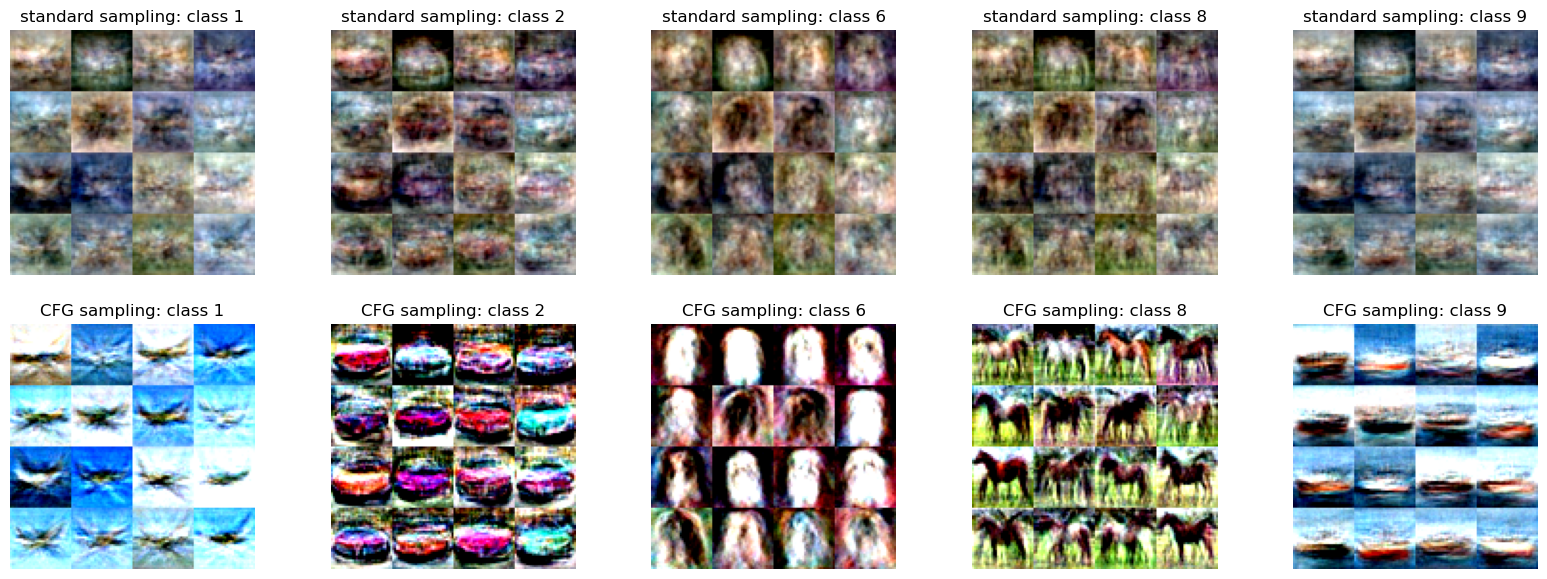

In [52]:
# Prepare EDM model
net_cond_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-ve.pkl'
with dnnlib.util.open_url(net_cond_pkl) as f:
    net_cond = pickle.load(f)['ema'].to(device)
    
rank = 3*32*32 # we use full rank here to avoid the singularity of score functions near zero noise
# Prepare unconditional linear diffusion model
mean_path_uncond = 'Covariance_Cifar/50000/mean.pt'
covariance_path_uncond = 'Covariance_Cifar/50000/covariance.pt' 
mean_uncond = torch.load(mean_path_uncond, weights_only=False)
mean_uncond = mean_uncond.to(device)
U, S, Vh = torch.load(covariance_path_uncond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)

torch.manual_seed(0)
num_show = 16 # number of generated samples
num_steps = 10 # number of reverse sampling steps
num_channels = 3
resolution = 32
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device) # initial noise
guidance_strength = 4 # guidance strength
interval = (80.0, 0) # interval in which CFG is used, in this example, cfg is used at every noise level

covariance_uncond = U, S, Vh

Gaussian_model_uncond = multi_gaussian(mean_uncond, covariance_uncond, low_rank=rank).to(device)

class_idx_list = [0,1,5,7,8] #[0,1,2,3,4,5,6,7,8,9] 

naive_conditional_sampling_list = []
cfg_sampling_list = []

guidance_strength = 4

for i in range(len(class_idx_list)):
    mean_path_cond = 'Covariance_Cifar/class'+str(class_idx_list[i])+'/mean.pt'
    covariance_path_cond = 'Covariance_Cifar/class'+str(class_idx_list[i])+'/covariance.pt'
    mean_cond = torch.load(mean_path_cond, weights_only=False)
    mean_cond = mean_cond.to(device)
    U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
    U = U.to(device)
    S = S.to(device)
    Vh = Vh.to(device)
    covariance_cond = U, S, Vh
    Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)
    sigma_list, _, denoised_intermediates_Gaussian_cond = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents, num_steps=num_steps, device=device) # note we pass the EDM model (net_cond) here only for constructing the sampling schedule, the samples are purely generated by the linear model
    sigma_list, _, denoised_intermediates_Gaussian_cfg_cond, _ = generate_image_Gaussian_cfg(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, device=device)
    naive_conditional_sampling_list.append(denoised_intermediates_Gaussian_cond[-1])
    cfg_sampling_list.append(denoised_intermediates_Gaussian_cfg_cond[-1])
    

plt.figure(figsize=(20,7))
for i in range(len(class_idx_list)):
    plt.subplot(2,len(class_idx_list),1+i)
    plt.title('standard sampling:'+' class '+str(class_idx_list[i]+1))
    plt.imshow(get_image_grid(naive_conditional_sampling_list[i], num_row=4, num_col=4, resolution=32, clip=True))
    plt.axis('off')
    plt.subplot(2, len(class_idx_list), 1+i+len(class_idx_list))
    plt.title('CFG sampling:'+' class '+str(class_idx_list[i]+1))
    plt.imshow(get_image_grid(cfg_sampling_list[i], num_row=4, num_col=4, resolution=32, clip=True))
    plt.axis('off')
plt.show()

### ImageNet

100%|██████████| 10/10 [00:00<00:00, 61.98step/s]


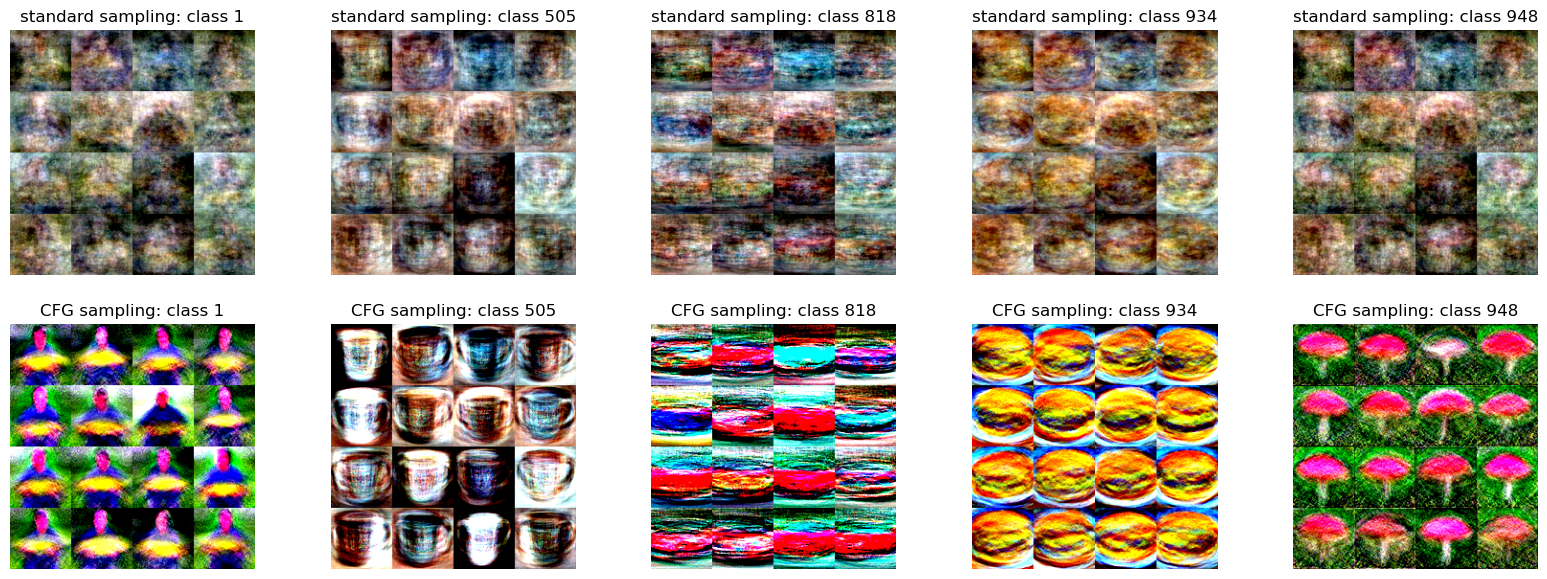

In [53]:
net_cond_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-imagenet-64x64-cond-adm.pkl'
with dnnlib.util.open_url(net_cond_pkl) as f:
    net_cond = pickle.load(f)['ema'].to(device)
    
rank = 3*64*64 # we use full rank here to avoid the singularity of score functions near zero noise
# Prepare unconditional linear diffusion model
mean_path_uncond = 'Covariance_ImageNetGenerated/uncond/mean.pt'
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
mean_uncond = torch.load(mean_path_uncond, weights_only=False)
mean_uncond = mean_uncond.to(device)
U, S, Vh = torch.load(covariance_path_uncond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)

torch.manual_seed(0)
num_show = 16 # number of generated samples
num_steps = 10 # number of reverse sampling steps
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device) # initial noise
guidance_strength = 4 # guidance strength
interval = (80.0, 0) # interval in which CFG is used, in this example, cfg is used at every noise level
covariance_uncond = U, S, Vh

Gaussian_model_uncond = multi_gaussian(mean_uncond, covariance_uncond, low_rank=rank).to(device)

class_idx_list = [0, 504, 817, 933, 947]


naive_conditional_sampling_list = []
cfg_sampling_list = []

guidance_strength = 4

for i in range(len(class_idx_list)):
    mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx_list[i])+'/mean.pt'
    covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx_list[i])+'/covariance.pt'
    mean_cond = torch.load(mean_path_cond, weights_only=False)
    mean_cond = mean_cond.to(device)
    U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
    U = U.to(device)
    S = S.to(device)
    Vh = Vh.to(device)
    covariance_cond = U, S, Vh
    Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)
    sigma_list, _, denoised_intermediates_Gaussian_cond = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents, num_steps=num_steps, device=device) # note we pass the EDM model (net_cond) here only for constructing the sampling schedule, the samples are purely generated by the linear model
    sigma_list, _, denoised_intermediates_Gaussian_cfg_cond, _ = generate_image_Gaussian_cfg(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, device=device)
    naive_conditional_sampling_list.append(denoised_intermediates_Gaussian_cond[-1])
    cfg_sampling_list.append(denoised_intermediates_Gaussian_cfg_cond[-1])
    

plt.figure(figsize=(20,7))
for i in range(len(class_idx_list)):
    plt.subplot(2,len(class_idx_list),1+i)
    plt.title('standard sampling:'+' class '+str(class_idx_list[i]+1))
    plt.imshow(get_image_grid(naive_conditional_sampling_list[i], num_row=4, num_col=4, resolution=64, clip=True))
    plt.axis('off')
    plt.subplot(2, len(class_idx_list), 1+i+len(class_idx_list))
    plt.title('CFG sampling:'+' class '+str(class_idx_list[i]+1))
    plt.imshow(get_image_grid(cfg_sampling_list[i], num_row=4, num_col=4, resolution=64, clip=True))
    plt.axis('off')
plt.show()

### Perhaps surprisingly, despite being built from class-specific covariances, the naive conditional samples look highly similar. Remember from eq. (8) of the paper, the linear sampling trajectory is governed by the data covariances: x_t is a weighted combination of principal components (PCs), where the weights emphasize the leading PCs. Therefore, the lack of class-specificity of the generated samples indicate the data covariances do not adequately capture the class-specific patterns. Below, we validate this argument with the following experiments: (i) quantitatively, the leading PCs of conditional covariances well align with those of the unconditional dataset, and (ii) qualitatively, the leading PCs of conditional covariances do not reflect class-specific patterns, but more like capturing generic features such as foreground-background variations.

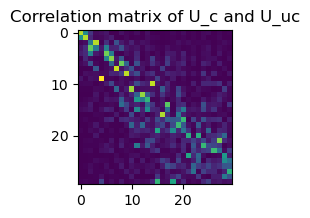

0th singular vector of cond
0th singular vector of uncond
u_c@u_uc=tensor(0.8632, device='cuda:0')


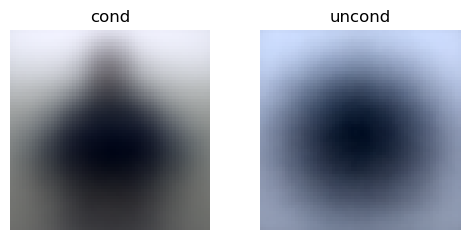

1th singular vector of cond
1th singular vector of uncond
u_c@u_uc=tensor(0.8562, device='cuda:0')


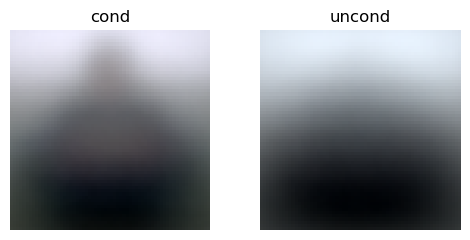

2th singular vector of cond
3th singular vector of uncond
u_c@u_uc=tensor(0.8634, device='cuda:0')


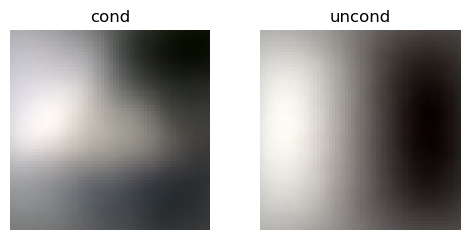

7th singular vector of cond
7th singular vector of uncond
u_c@u_uc=tensor(0.8917, device='cuda:0')


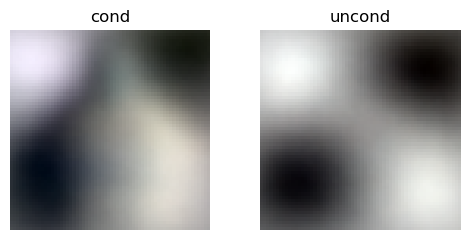

8th singular vector of cond
9th singular vector of uncond
u_c@u_uc=tensor(0.8717, device='cuda:0')


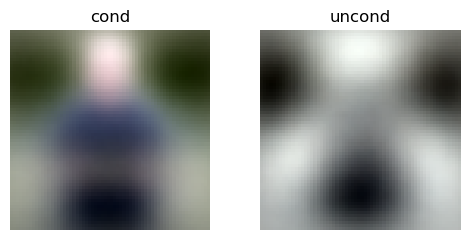

9th singular vector of cond
4th singular vector of uncond
u_c@u_uc=tensor(0.9686, device='cuda:0')


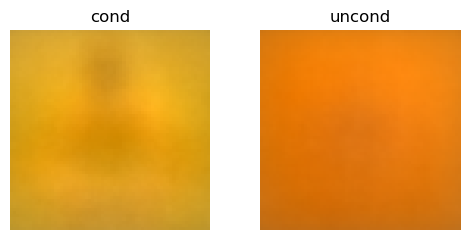

10th singular vector of cond
14th singular vector of uncond
u_c@u_uc=tensor(0.8744, device='cuda:0')


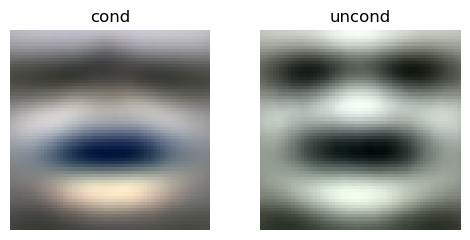

11th singular vector of cond
10th singular vector of uncond
u_c@u_uc=tensor(0.8281, device='cuda:0')


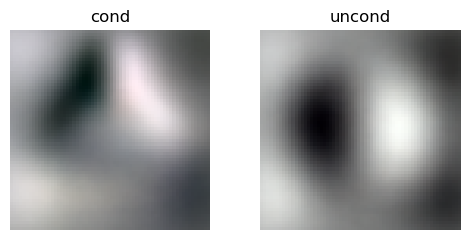

12th singular vector of cond
12th singular vector of uncond
u_c@u_uc=tensor(0.8113, device='cuda:0')


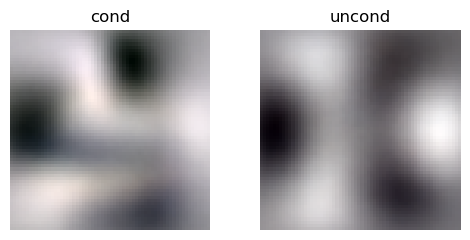

16th singular vector of cond
16th singular vector of uncond
u_c@u_uc=tensor(0.8491, device='cuda:0')


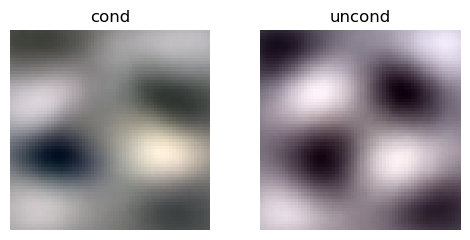

In [54]:
class_idx = 0 # Choose class 1 (tench) as an example, the results are consistent for other classes
resolution = 64 # 32 for cifar

# Load conditional (c) covariance
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
U_c, S_c, Vh_c = torch.load(covariance_path_cond, weights_only=False)
U_c = U_c.to(device)
S_c = S_c.to(device)
Vh_c = Vh_c.to(device)


# Load unconditional (uc) covariance
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
U_uc, S_uc, Vh_uc = torch.load(covariance_path_uncond, weights_only=False)
U_uc = U_uc.to(device)
S_uc = S_uc.to(device)
Vh_uc = Vh_uc.to(device)

# Match the singular vectors of the conditional covariance and unconditional covariance.
# This step is necessary, because the matched singular vectors of U_c and U_uc might not appear at the eaxct same index.
row_indices, col_indices, similarity_matrix = find_optimal_with_sign(U_c, U_uc)

#The following plot shows that the leading PCs of conditional data matches those of the unconditional data, hence they fail to capture class-specific patterns')
plt.figure(figsize=(2,2))
plt.title('Correlation matrix of U_c and U_uc')
plt.imshow(normalize_np(similarity_matrix[0:30,0:30]))
plt.show()

# Below we visualize conditional and unconditional PCs that have a cosine similarity higher than 0.8
# Note how these PCs do not capture the class-specific patterns, but more likely be the generic features
similarities = similarity_matrix[row_indices, col_indices]
success_thresh = 0.8
success_indices = np.where(similarities >= success_thresh)[0]
row_indices_success = [row_indices[i] for i in success_indices]
col_indices_success = [col_indices[i] for i in success_indices]
for i in range(len(success_indices)):
    print(str(row_indices_success[i])+'th singular vector of cond')
    print(str(col_indices_success[i])+'th singular vector of uncond')
    u_c = U_c[:,row_indices_success[i]]
    u_uc = U_uc[:,col_indices_success[i]]
    if u_c.T@u_uc <0:
        u_c = -u_c
    print('u_c@u_uc='+str(u_c.T@u_uc))
    fig = plt.figure(figsize=(5,2))
    plt.subplot(121)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.title('cond')
    plt.imshow(normalize_image(u_c).reshape(3,resolution,resolution).permute(1,2,0).cpu())
    plt.axis('off')

    plt.subplot(122)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    plt.title('uncond')
    plt.imshow(normalize_image(u_uc).reshape(3,resolution,resolution).permute(1,2,0).cpu())
    plt.axis('off')
    plt.show()

# Note CFG greatly enhance the class-specific patterns. How does it achieve so? As shown in the paper, it actually enhances the positive contrastive principal components, suppresses the negative principal components, and shift the samples approximately towards class means. Next, we visualize these features.

### (1) We start by visualizing the CPCs of the clean data covariances (clean data distribution). We will later visualize CPCs of the posterior covariances for the noisy data distribution. We first show that the eigen spectrum of U_c-U_uc has both positive and negative eigen values. The eigen vectors correspond to positive eigen values are the positive CPCs, which span the subspace that best fit the conditional data while being as far as possible from the unconditional data. On the other hand, the eigen vectors correspond to negative eigen values are the negative CPCs, which span the subspace that best fit the unconditional data while being as far as possible from the conditional data.

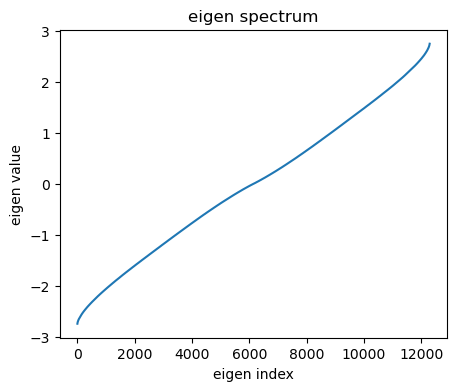

In [55]:
class_idx = 0 # Choose class 1 (tench) as an example, the results are consistent for other classes
resolution = 64 # 32 for cifar

# Load conditional (c) covariance
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
U_c, S_c, Vh_c = torch.load(covariance_path_cond, weights_only=False)
U_c = U_c.to(device)
S_c = S_c.to(device)
Vh_c = Vh_c.to(device)


# Load unconditional (uc) covariance
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
U_uc, S_uc, Vh_uc = torch.load(covariance_path_uncond, weights_only=False)
U_uc = U_uc.to(device)
S_uc = S_uc.to(device)
Vh_uc = Vh_uc.to(device)


covariance_cpc = U_c - U_uc
S_cpc, U_cpc = torch.linalg.eigh(covariance_cpc)

# Visualize eigen spectrum
plt.figure(figsize=(5,4))
plt.title('eigen spectrum')
plt.plot(S_cpc.cpu())
plt.xlabel('eigen index')
plt.ylabel('eigen value')
plt.show()

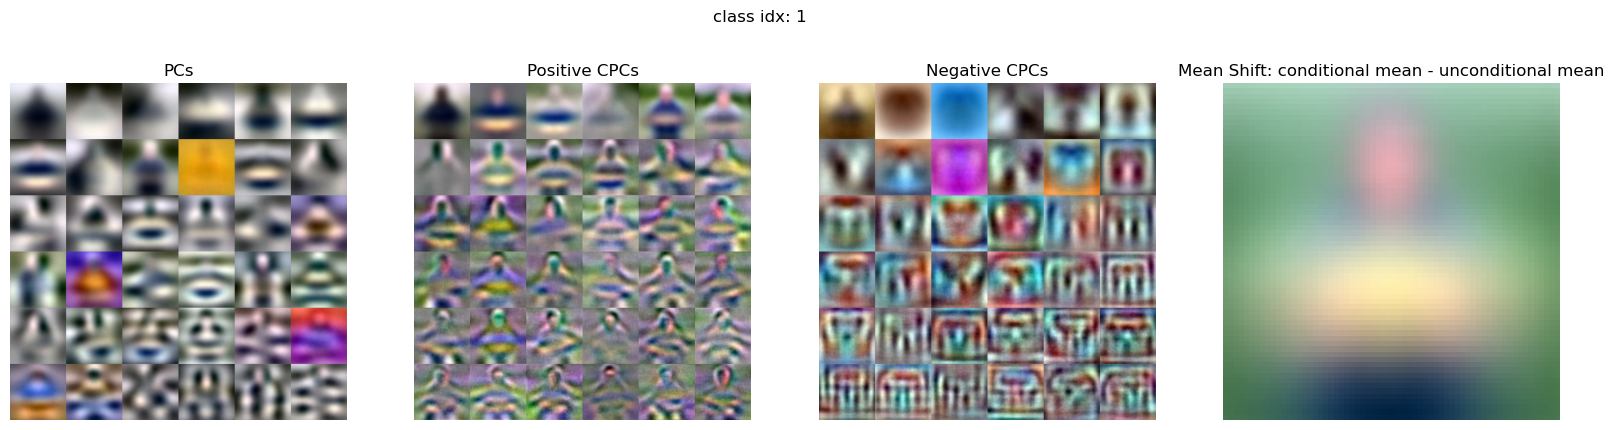

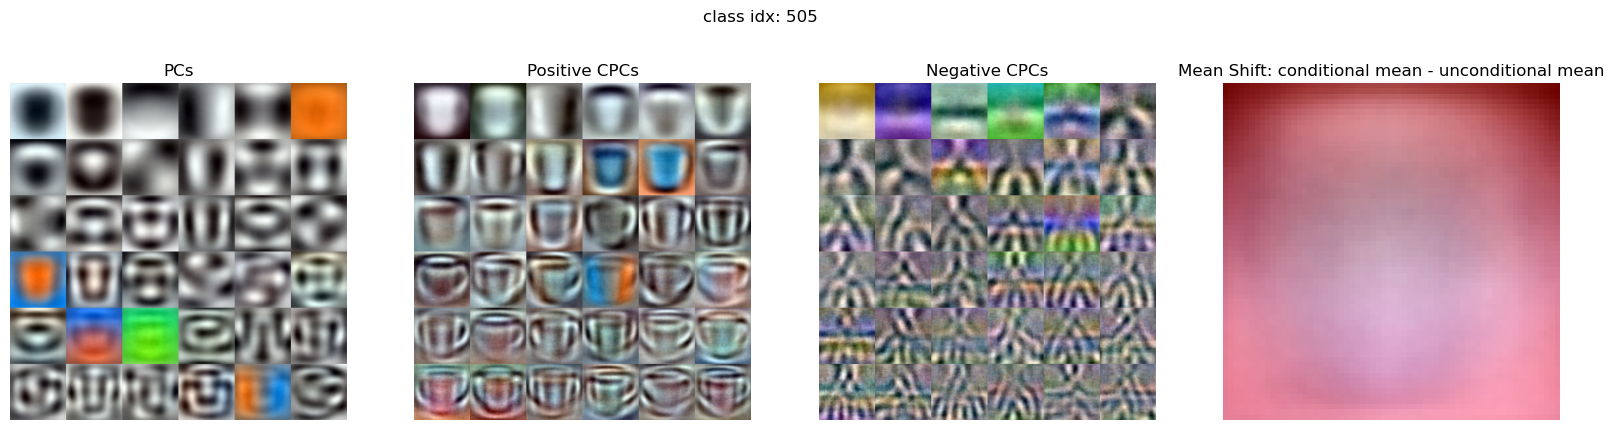

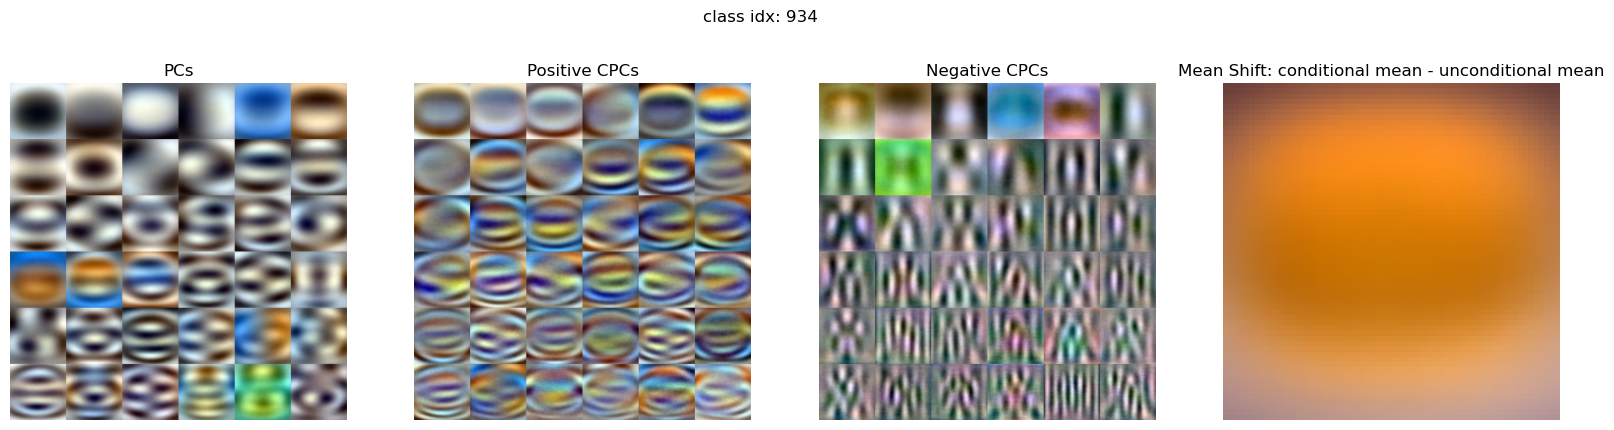

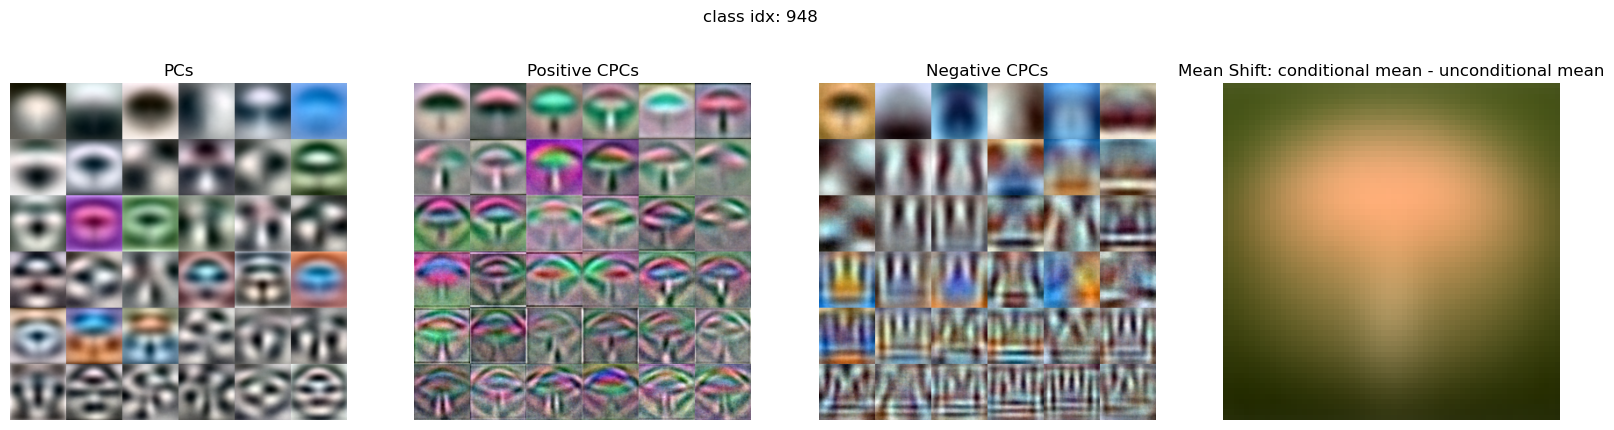

In [56]:
# Visualize PCs, Positive CPCs and Negative CPCs for ImageNet
mean_uncond = torch.load('Covariance_ImageNetGenerated/uncond/mean.pt', weights_only=False)
num_show = 36
class_idx_list = [0, 504, 933, 947]#[0,31,64,207,430,483,504,817,933,947]
for i in class_idx_list:
    mean_cond = torch.load(os.path.join('Covariance_ImageNetGenerated', 'class_'+str(i), 'mean.pt'), weights_only=False)
    U, S, Vh = torch.load(os.path.join('Covariance_ImageNetGenerated', 'class_'+str(i), 'covariance.pt'), weights_only=False, map_location=device)
    U_uc, S_uc, Vh_uc = torch.load('Covariance_ImageNetGenerated/uncond/covariance.pt', weights_only=False, map_location=device)
    covariance_cond = U@torch.diag(S)@Vh
    covariance_uncond = U_uc@torch.diag(S_uc)@Vh_uc
    S_cpc, U_cpc = torch.linalg.eigh(covariance_cond-covariance_uncond)
    U_show = U[:,:num_show]
    U_cpc_neg_show = U_cpc[:,:num_show]
    U_cpc_pos_show = U_cpc[:,-num_show:].flip(dims=[1])
    # independently normalize each column
    for j in range(U_show.shape[1]):
        temp = U_show[:,j]
        temp = normalize_image(temp, clip=False)
        U_show[:,j] = temp
        temp = U_cpc_neg_show[:,j]
        temp = normalize_image(temp, clip=False)
        U_cpc_neg_show[:,j] = temp
        temp = U_cpc_pos_show[:,j]
        temp = normalize_image(temp, clip=False)
        U_cpc_pos_show[:,j] = temp
    
    U_show = U_show.permute(1,0).reshape(int(np.sqrt(num_show)),int(np.sqrt(num_show)),3,64,64)
    U_show = U_show.permute(0,3,1,4,2)
    U_show = U_show.reshape(int(np.sqrt(num_show))*64,int(np.sqrt(num_show))*64,3)
    
    U_cpc_neg_show = U_cpc_neg_show.permute(1,0).reshape(int(np.sqrt(num_show)),int(np.sqrt(num_show)),3,64,64)
    U_cpc_neg_show = U_cpc_neg_show.permute(0,3,1,4,2)
    U_cpc_neg_show = U_cpc_neg_show.reshape(int(np.sqrt(num_show))*64,int(np.sqrt(num_show))*64,3)
    
    U_cpc_pos_show = U_cpc_pos_show.permute(1,0).reshape(int(np.sqrt(num_show)),int(np.sqrt(num_show)),3,64,64)
    U_cpc_pos_show = U_cpc_pos_show.permute(0,3,1,4,2)
    U_cpc_pos_show = U_cpc_pos_show.reshape(int(np.sqrt(num_show))*64,int(np.sqrt(num_show))*64,3)
    
    plt.figure(figsize=(20,5))
    plt.suptitle('class idx: '+str(i+1))
    plt.subplot(141)
    plt.title('PCs')
    plt.imshow(U_show.detach().cpu())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
    plt.subplot(142)
    plt.title('Positive CPCs')
    plt.imshow(U_cpc_pos_show.detach().cpu())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
    plt.subplot(143)
    plt.title('Negative CPCs')
    plt.imshow(U_cpc_neg_show.detach().cpu())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
    plt.subplot(144)
    plt.title('Mean Shift: conditional mean - unconditional mean')
    plt.imshow(normalize_image((mean_cond-mean_uncond)).detach().cpu().reshape(3,64,64).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
        
    plt.show()

### (2) We've demonstrated the CPCs correspond to the clean data distribution. But in diffusion sampling, the CPCs and mean-shift components are evolving with the noise levels across different time steps, i.e., they should be calculated based on the posterior covariance. Next, we demonstrate this evolution. We will not visualize negative CPCs as they represent the generic features prevalent in the unconditional data, hence are less visually interpretable.

Evolution of mean-shift component:


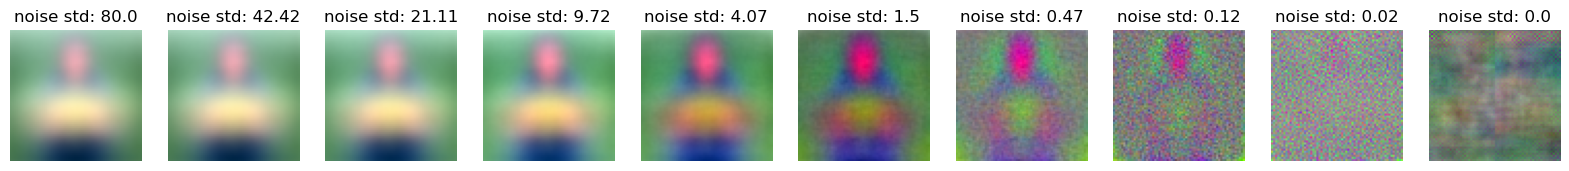

Evolution of positive CPCs:


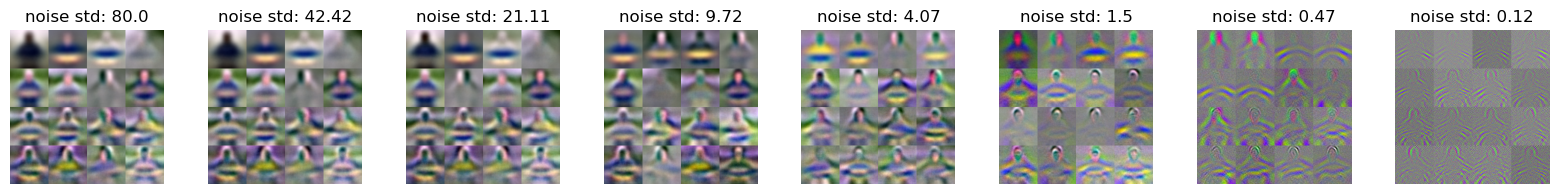

In [57]:
class_idx = 0 # we focus on the class tench

# Load unconditional mean and unconditional covariance 
mean_path_uncond = 'Covariance_ImageNetGenerated/uncond/mean.pt'
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
mean_uncond = torch.load(mean_path_uncond, weights_only=False)
mean_uncond = mean_uncond.to(device)
U_uc, S_uc, Vh_uc = torch.load(covariance_path_uncond, weights_only=False)
U_uc = U_uc.to(device)
S_uc = S_uc.to(device)
Vh_uc = Vh_uc.to(device)

# Load conditional mean and conditional covariance
mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/mean.pt'
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
mean_cond = torch.load(mean_path_cond, weights_only=False)
mean_cond = mean_cond.to(device)
U_c, S_c, Vh_c = torch.load(covariance_path_cond, weights_only=False)
U_c = U_c.to(device)
S_c = S_c.to(device)
Vh_c = Vh_c.to(device)

# First visualize evolution of mean-shift component
mean_shift = mean_cond - mean_uncond
plt.figure(figsize=(20,2))
print('Evolution of mean-shift component:')
for i in range(len(sigma_list)):
    sigma = sigma_list[i]
    cov_uncond = U_uc@torch.diag(S_uc/(S_uc+sigma**2))@Vh_uc
    cov_uncond = cov_uncond.to(latents.device)
    guidance_direction = (mean_shift - cov_uncond@mean_shift) / sigma
    guidance_direction = guidance_direction.reshape(1,3,64,64)[0]
    plt.subplot(1,len(sigma_list),i+1)
    plt.title('noise std: '+str(round(sigma, 2)))
    plt.imshow(normalize_image(guidance_direction).permute(1,2,0).to(device).to('cpu').numpy())
    plt.axis('off')
plt.show()

# Then visualize evolution of (first 16) positive CPCs
plt.figure(figsize=(20,2))
print('Evolution of positive CPCs:')
num_show = 16
for i in range(len(sigma_list)-2): 
    sigma = sigma_list[i]
    cov_uncond = U_uc@torch.diag(S_uc/(S_uc+sigma**2))@Vh_uc
    cov_uncond = cov_uncond.to(latents.device)
    
    cov_cond = U_c@torch.diag(S_c/(S_c+sigma**2))@Vh_c
    cov_cond = cov_cond.to(latents.device)
    
    _, U_cpc = torch.linalg.eigh(cov_cond - cov_uncond)
    U_cpc_pos = U_cpc[:,-num_show:].flip(dims=[1])
    
    # normalize each CPC independently for visualization purpose
    for k in range(U_cpc_pos.shape[1]):
        temp = U_cpc_pos[:,k]
        temp = normalize_image(temp)
        U_cpc_pos[:,k] = temp

    U_cpc_pos = U_cpc_pos.permute(1,0).reshape(int(np.sqrt(num_show)),int(np.sqrt(num_show)),3,64,64)
    U_cpc_pos = U_cpc_pos.permute(0,3,1,4,2)
    U_cpc_pos = U_cpc_pos.reshape(int(np.sqrt(num_show))*64,int(np.sqrt(num_show))*64,3)
    
    plt.subplot(1, len(sigma_list)-2, i+1)
    plt.title('noise std: '+str(round(sigma, 2)))
    plt.imshow(U_cpc_pos.cpu())
    plt.axis('off')
plt.show()

### (3) Based on the analyses, CFG should enhance the positive CPCs, suppress negative CPCs and push the samples towards the direction of mean-shift term. We next validate these arguments quantitatively by doing projection experiments described in section 3 of the paper. Specifically, for a chosen class, we generate 1000 samples using naive conditional sampling and 1000 samples using CFG respectively, centered them by class mean, and project them on the positive CPCs, negative CPCs and mean-shift term to obtain a series of univariate distributions separately. We should observe that samples generated with CFG will have higher projection value along positive CPCs, lower projection values along negative CPCs and higher projection values along mean-shift direction.

In [58]:
class_idx = 0 # we use tench class as an example, the observations should hold on other classes as well
mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/mean.pt'
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
mean_cond = torch.load(mean_path_cond, weights_only=False)
mean_cond = mean_cond.to(device)
U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
covariance_cond = U, S, Vh
Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)

U_uc, S_uc, Vh_uc = torch.load('Covariance_ImageNetGenerated/uncond/covariance.pt', weights_only=False, map_location=device)
covariance_uncond = U_uc@torch.diag(S_uc)@Vh_uc
S_cpc, U_cpc = torch.linalg.eigh(U@torch.diag(S)@Vh-covariance_uncond)



num_show = 1000 # number of generated samples
num_steps = 10 # number of reverse sampling steps
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device) # initial noise
guidance_strength = 4 # guidance strength
interval = (80.0, 0) # interval in which CFG is used, in this example, cfg is used at every noise level
sigma_list, _, denoised_intermediates_Gaussian_cond = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents, num_steps=num_steps, device=device) # note we pass the EDM model (net_cond) here only for constructing the sampling schedule, the samples are purely generated by the linear model
sigma_list, _, denoised_intermediates_Gaussian_cfg_cond, _ = generate_image_Gaussian_cfg(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, device=device)

cfg_samples = denoised_intermediates_Gaussian_cfg_cond[-1]
cfg_samples = cfg_samples.reshape(cfg_samples.shape[0], -1).to(device).to(torch.float32) # reshape to (N,C*H*W)
naive_conditional_samples = denoised_intermediates_Gaussian_cond[-1]
naive_conditional_samples = naive_conditional_samples.reshape(naive_conditional_samples.shape[0], -1).to(device).to(torch.float32)

cpc_index = 0 # index of the cpc for performing projection, you might change this index at will
U_cpc_pos = U_cpc[:,-(class_idx+1)].reshape(-1,1)
U_cpc_neg = U_cpc[:,class_idx].reshape(-1,1)
mean_shift = mean_cond - mean_uncond

coeffs_positive_cpc_cond = abs((naive_conditional_samples-mean_cond)@U_cpc_pos)
coeffs_positive_cpc_cfg= abs((cfg_samples-mean_cond)@U_cpc_pos)

coeffs_negative_cpc_cond = abs((naive_conditional_samples-mean_cond)@U_cpc_neg)
coeffs_negative_cpc_cfg= abs((cfg_samples-mean_cond)@U_cpc_neg)

coeffs_mean_shift_cond = (naive_conditional_samples-mean_cond)@U_cpc_neg
coeffs_mean_shift_cfg= (cfg_samples-mean_cond)@U_cpc_neg

100%|██████████| 10/10 [00:03<00:00,  2.74step/s]


Univariate Distributions for Samples from linear diffusion model:


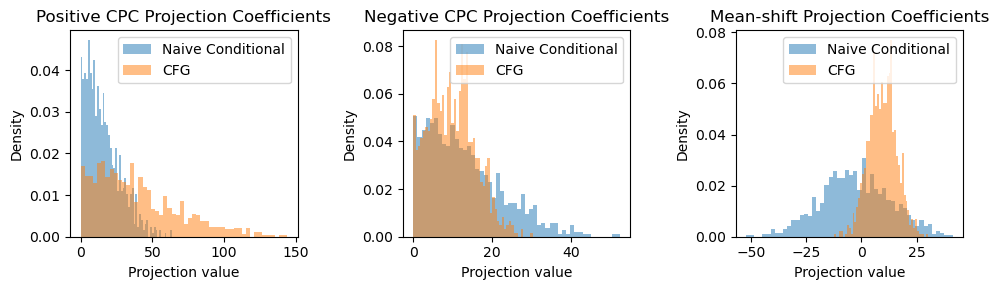

In [59]:
print('Univariate Distributions for Samples from linear diffusion model:')


plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(coeffs_positive_cpc_cond.flatten().cpu(), bins=50, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_positive_cpc_cfg.flatten().cpu(), bins=50, alpha=0.5, label='CFG', density=True)
plt.title('Positive CPC Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.subplot(132)
plt.hist(coeffs_negative_cpc_cond.flatten().cpu(), bins=50, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_negative_cpc_cfg.flatten().cpu(), bins=50, alpha=0.5, label='CFG', density=True)
plt.title('Negative CPC Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()


plt.subplot(133)
plt.hist(coeffs_mean_shift_cond.flatten().cpu(), bins=50, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_mean_shift_cfg.flatten().cpu(), bins=50, alpha=0.5, label='CFG', density=True)
plt.title('Mean-shift Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.show()

### The univariate distributions above are computed from samples of linear diffusion models, but the same trend holds on actual nonlinear diffusion models as well.

100%|██████████| 10/10 [00:05<00:00,  1.71step/s]


Univariate Distributions for Samples from EDM model:


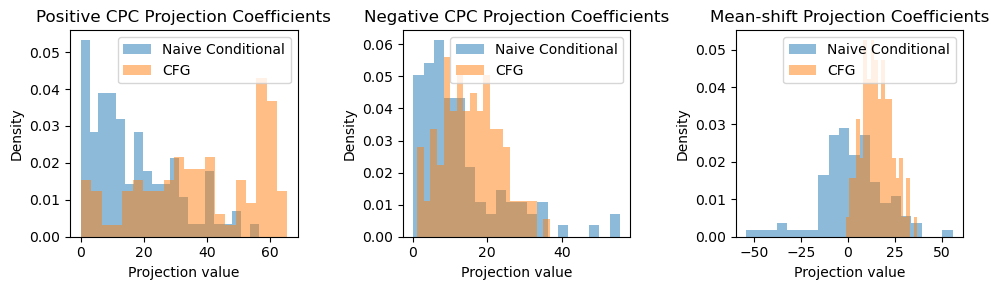

In [63]:
torch.manual_seed(0)

# Load conditional EDM model
net_cond_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-imagenet-64x64-cond-adm.pkl'
with dnnlib.util.open_url(net_cond_pkl) as f:
    net_cond = pickle.load(f)['ema'].to(device)

# Load unconditional EDM model, this one is trained by ourselves from scratch
net_uncond_pkl = 'Imagenet_weights/network-snapshot-048000.pkl'

with dnnlib.util.open_url(net_uncond_pkl) as f:
    net_uncond = pickle.load(f)['ema'].to(device)

class_idx = 0

# we only use 100 samples here so that we can run the code and demonstrate in jupyter notebook, 
# but the results in the paper are computed over 1000 samples using a separate scripts,
# the results will hold the same if more samples are used for computing the univariate distributions.

num_steps = 10
num_show = 100
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device)
guidance_strength = 5

interval = (80.0, 0.02)
    
# Standard (naive) conditional generation with EDM
sigma_list, _, denoised_intermediates_EDM_cond = generate_image(net_cond, latents, num_steps=num_steps, class_idx=class_idx, device=device)

# CFG generation with EDM model (interval 1)
sigma_list, _, denoised_intermediates_EDM_cfg_cond, denoised_intermediates_EDM_cfg_uncond = generate_image_EDM_cfg_limited_interval(net_uncond, net_cond, latents , guidance_strength, interval[0], interval[1], num_steps=num_steps, class_idx=class_idx, device=device)

cfg_samples = denoised_intermediates_EDM_cfg_cond[-1]
cfg_samples = cfg_samples.reshape(cfg_samples.shape[0], -1).to(device).to(torch.float32) # reshape to (N,C*H*W)
naive_conditional_samples = denoised_intermediates_EDM_cond[-1]
naive_conditional_samples = naive_conditional_samples.reshape(naive_conditional_samples.shape[0], -1).to(device).to(torch.float32)

cpc_index = 0 # index of the cpc for performing projection, you might change this index at will
U_cpc_pos = U_cpc[:,-(class_idx+1)].reshape(-1,1)
U_cpc_neg = U_cpc[:,class_idx].reshape(-1,1)
mean_shift = mean_cond - mean_uncond

coeffs_positive_cpc_cond = abs((naive_conditional_samples-mean_cond)@U_cpc_pos)
coeffs_positive_cpc_cfg= abs((cfg_samples-mean_cond)@U_cpc_pos)

coeffs_negative_cpc_cond = abs((naive_conditional_samples-mean_cond)@U_cpc_neg)
coeffs_negative_cpc_cfg= abs((cfg_samples-mean_cond)@U_cpc_neg)

coeffs_mean_shift_cond = (naive_conditional_samples-mean_cond)@U_cpc_neg
coeffs_mean_shift_cfg= (cfg_samples-mean_cond)@U_cpc_neg

# Below we use less bins (20) compared to the linear model case since we are use 10 times less samples
print('Univariate Distributions for Samples from EDM model:')
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(coeffs_positive_cpc_cond.flatten().cpu(), bins=20, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_positive_cpc_cfg.flatten().cpu(), bins=20, alpha=0.5, label='CFG', density=True)
plt.title('Positive CPC Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.subplot(132)
plt.hist(coeffs_negative_cpc_cond.flatten().cpu(), bins=20, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_negative_cpc_cfg.flatten().cpu(), bins=20, alpha=0.5, label='CFG', density=True)
plt.title('Negative CPC Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()


plt.subplot(133)
plt.hist(coeffs_mean_shift_cond.flatten().cpu(), bins=20, alpha=0.5, label='Naive Conditional', density=True)
plt.hist(coeffs_mean_shift_cfg.flatten().cpu(), bins=20, alpha=0.5, label='CFG', density=True)
plt.title('Mean-shift Projection Coefficients')
plt.xlabel('Projection value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.show()

### (4) Having quantitatively demonstrated the effects of the three CFG components, now we visualize their effects qualitatively by applying them in isolation. We summarize key observations as follows: (i) positive CPC guidance significantly enhances the positive CPC features in the generated samples, leading to visually pronounced class-specific patterns, (ii) negative CPC guidance mainly removes some background clutters, rather than drastically change the samples, and (iii) mean-shift guidance enhances the features of class mean, since it is uniform across all samples, it reduces sample diversity.

In [70]:
rank = 3*64*64 # we use full rank here to avoid the singularity of score functions near zero noise
# Prepare unconditional linear diffusion model
mean_path_uncond = 'Covariance_ImageNetGenerated/uncond/mean.pt'
covariance_path_uncond = 'Covariance_ImageNetGenerated/uncond/covariance.pt' 
mean_uncond = torch.load(mean_path_uncond, weights_only=False)
mean_uncond = mean_uncond.to(device)
U, S, Vh = torch.load(covariance_path_uncond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)

torch.manual_seed(0)
num_show = 16 # number of generated samples
num_steps = 10 # number of reverse sampling steps
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device) # initial noise
guidance_strength = 4 # guidance strength
interval = (80.0, 0.02) # interval in which CFG is used, in this example, cfg is used at every noise level
covariance_uncond = U, S, Vh

Gaussian_model_uncond = multi_gaussian(mean_uncond, covariance_uncond, low_rank=rank).to(device)

class_idx = 0

guidance_strength = 6 #4

mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/mean.pt'
covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
mean_cond = torch.load(mean_path_cond, weights_only=False)
mean_cond = mean_cond.to(device)
U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)
covariance_cond = U, S, Vh
Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)
sigma_list, _, denoised_intermediates_Gaussian_cond = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents, num_steps=num_steps, device=device) # note we pass the EDM model (net_cond) here only for constructing the sampling schedule, the samples are purely generated by the linear model
sigma_list, _, denoised_intermediates_Gaussian_cfg_cond, _ = generate_image_Gaussian_cfg(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, device=device)
sigma_list, _, denoised_intermediates_Gaussian_positive_cpc = generate_image_pure_Gaussian_cpc_limited_interval(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, sigma_high=interval[0], sigma_low=interval[1], guide_type='pos')
sigma_list, _, denoised_intermediates_Gaussian_negative_cpc = generate_image_pure_Gaussian_cpc_limited_interval(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, sigma_high=interval[0], sigma_low=interval[1], guide_type='neg')
sigma_list, _, denoised_intermediates_Gaussian_mean_shift = generate_image_pure_Gaussian_cpc_limited_interval(net_cond, Gaussian_model_cond, Gaussian_model_uncond, latents, guidance_strength=guidance_strength, num_steps=num_steps, sigma_high=interval[0], sigma_low=interval[1], guide_type='mean_shift')


100%|██████████| 10/10 [00:11<00:00,  1.17s/step]


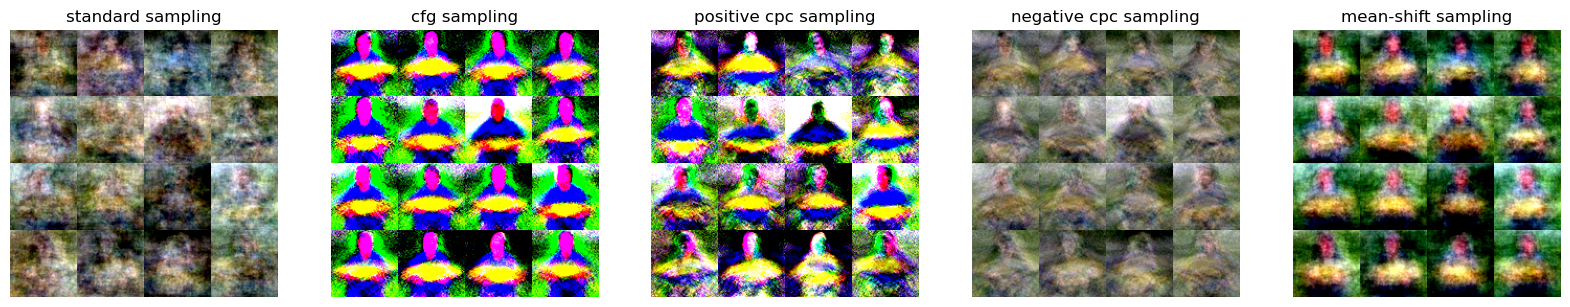

In [71]:
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.title('standard sampling')
plt.imshow(get_image_grid(denoised_intermediates_Gaussian_cond[-1], num_row=4, num_col=4, resolution=64, clip=True))
plt.axis('off')
plt.subplot(1,5,2)
plt.title('cfg sampling')
plt.imshow(get_image_grid(denoised_intermediates_Gaussian_cfg_cond[-1], num_row=4, num_col=4, resolution=64, clip=True))
plt.axis('off')
plt.subplot(1,5,3)
plt.title('positive cpc sampling')
plt.imshow(get_image_grid(denoised_intermediates_Gaussian_positive_cpc[-1], num_row=4, num_col=4, resolution=64, clip=True))
plt.axis('off')
plt.subplot(1,5,4)
plt.title('negative cpc sampling')
plt.imshow(get_image_grid(denoised_intermediates_Gaussian_negative_cpc[-1], num_row=4, num_col=4, resolution=64, clip=True))
plt.axis('off')
plt.subplot(1,5,5)
plt.title('mean-shift sampling')
plt.imshow(get_image_grid(denoised_intermediates_Gaussian_mean_shift[-1], num_row=4, num_col=4, resolution=64, clip=True))
plt.axis('off')
plt.show()